In [1]:
import os
import matplotlib.pyplot as plt
import scanpy as sc
import deepstkit as dt

/data/hgh/anaconda3/envs/deepst-env/lib/python3.9/site-packages/louvain/__init__.py:54: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
# ========== Configuration ==========
SEED = 0                     # Random seed for reproducibility
DATA_DIR = "../data/DLPFC"   # Directory containing spatial data
SAMPLE_ID = "151674"         # Sample identifier to analyze
RESULTS_DIR = "./Results"   # Directory to save outputs
N_DOMAINS = 5 if SAMPLE_ID in ['151669', '151670', '151671', '151672'] else 7

# ========== Initialize Analysis ==========
# Set random seed and initialize DeepST
dt.utils_func.seed_torch(seed=SEED)

# Create DeepST instance with analysis parameters
deepst = dt.main.run(
    save_path=RESULTS_DIR,
    task="Identify_Domain",  # Spatial domain identification
    pre_epochs=500,          # Pretraining iterations
    epochs=500,              # Main training iterations
    use_gpu=True             # Accelerate with GPU if available
)

# ========== Data Loading & Preprocessing ==========
# (Optional) Load spatial transcriptomics data (Visium platform)
# e.g. adata = anndata.read_h5ad("*.h5ad"), this data including .obsm['spatial']
adata = deepst._get_adata(
    platform="Visium",
    data_path=DATA_DIR,
    data_name=SAMPLE_ID
)

# Optional: Incorporate H&E image features (skip if not available)
# adata = deepst._get_image_crop(adata, data_name=SAMPLE_ID)

# ========== Feature Engineering ==========
# Data augmentation (skip morphological if no H&E)
adata = deepst._get_augment(
    adata,
    spatial_type="BallTree",
    use_morphological = False  # Set True if using H&E features
)

# Construct spatial neighborhood graph
graph_dict = deepst._get_graph(
    adata.obsm["spatial"],
    distType="KDTree"        # Spatial relationship modeling
)

# Dimensionality reduction
data = deepst._data_process(
    adata,
    pca_n_comps=200          # Reduce to 200 principal components
)

# ========== Model Training ==========
# Train DeepST model and obtain embeddings
deepst_embed = deepst._fit(
    data=data,
    graph_dict=graph_dict
)
adata.obsm["DeepST_embed"] = deepst_embed

# ========== Spatial Domain Detection ==========
# Cluster spots into spatial domains
adata = deepst._get_cluster_data(
    adata,
    n_domains=N_DOMAINS,     # Expected number of domains
    priori=True              # Use prior knowledge if available
)

/data/hgh/anaconda3/envs/deepst-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/hgh/anaconda3/envs/deepst-env/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Spatial weights calculated. Average neighbors: 30.0
Gene expression weights calculated.
Final weight matrix calculated and stored in adata.obsm['weights_matrix_all']


Finding adjacent spots: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


Step 1: Data augmentation completed
12.0000 neighbors per cell on average.
Step 2: Spatial graph computation completed
Running DeepST analysis...


Pretraining initial model: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]
/data/hgh/anaconda3/envs/deepst-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Training final model: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ [ time left: 00:00 ]


Step 3: DeepST training completed
Memory usage: 4.28 GB
Total time: 0.66 minutes
Analysis completed successfully
Found resolution: 0.18 for 7 domains


In [3]:
from sklearn import metrics
import pandas as pd
df_meta = pd.read_csv(f"{DATA_DIR}/{SAMPLE_ID}/metadata.tsv", sep='\t')
adata.obs['Ground Truth'] = df_meta['layer_guess']

In [4]:
adata

AnnData object with n_obs × n_vars = 3673 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow', 'leiden', 'DeepST_domain', 'DeepST_refine_domain', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'neighbors', 'leiden', 'DeepST_domain'
    obsm: 'spatial', 'weights_matrix_all', 'adjacent_data', 'augment_gene_data', 'DeepST_embed'
    obsp: 'distances', 'connectivities'

In [5]:
from sklearn import metrics
obs_df = adata.obs.dropna()
ARI = metrics.adjusted_rand_score(obs_df['DeepST_refine_domain'], obs_df['Ground Truth'])
NMI = metrics.normalized_mutual_info_score(obs_df['DeepST_refine_domain'], obs_df['Ground Truth'])
print('Adjusted rand index = %.4f' %ARI)

Adjusted rand index = 0.5146


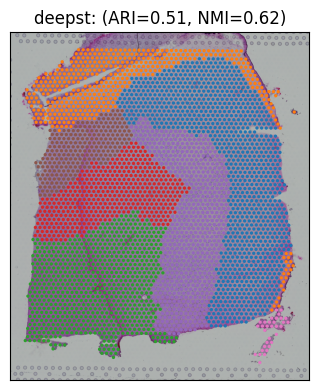

<Figure size 640x480 with 0 Axes>

In [6]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))

# 绘制空间数据并指定轴对象
sc.pl.spatial(
    adata,
    color="DeepST_refine_domain",
    title=('deepst: (ARI=%.2f, NMI=%.2f)' % (ARI, NMI)),
    ax=axs,
    show=False,
    legend_loc=None
)
axs.set_xlabel('')
axs.set_ylabel('')
plt.tight_layout() 
output_dir = ('./deepst_ARI_NMI')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, f"deepst_{SAMPLE_ID}_ARI.svg")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()
plt.clf()
plt.close(fig)

In [8]:
# 保存 adata 为 h5ad 文件
output_dir1 = ('./feature')
if not os.path.exists(output_dir1):
    os.makedirs(output_dir1)
output_path = os.path.join(output_dir1, f"151674-DeepST.h5ad")
adata.write_h5ad(output_path)